# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

Импорт библиотек:

In [1]:
!pip install scikit-learn==1.1.3
!pip install numpy
!pip install phik 
!pip install lightgbm

     |████████████████████████████████| 30.8 MB 1.1 MB/s eta 0:00:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
     |████████████████████████████████| 686 kB 1.1 MB/s eta 0:00:01


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import timeit
from sklearn.linear_model import LogisticRegression, LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error 
from phik.report import plot_correlation_matrix
from phik import report
from phik import phik_matrix
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Константы
RANDOM_STATE = 42
TEST_SIZE = 0.25


<div class="alert alert-block alert-success">
<b>Успех:</b> Импорты  как всегда на месте
</div>

### Выгрузка данных

In [4]:
# функция вывода информации о данных
def data_info(data):
    display(data.head(20))
    data.info()
    display(data.describe())

In [5]:
autos = pd.read_csv('/datasets/autos.csv')

In [6]:
data_info(autos)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


В данных довольно много пропусков, котоорые требуется обработать для корректного анализа. <br> Есть столбцы DateCrawled, DateCreated, LastSeen, которые имеют тип object, а должен быть формат даты.

### Изучение данных

Изменим тип данных у столбцов с датой:

In [7]:
autos['DateCrawled'] = pd.to_datetime(autos['DateCrawled'], format='%Y-%m-%dT%H:%M:%S')
autos['DateCreated'] = pd.to_datetime(autos['DateCrawled'], format='%Y-%m-%dT%H:%M:%S')
autos['LastSeen'] = pd.to_datetime(autos['LastSeen'], format='%Y-%m-%dT%H:%M:%S')

#### Изучение категориальных признаков

In [8]:
def data_unique(data):
    for row in data.columns:
        if data[row].dtype==object:
            print(f'Количество уникальных значений в столбце {row}:')
            print(len(data[row].unique()))
            print(data[row].value_counts())

In [9]:
data_unique(autos)

Количество уникальных значений в столбце VehicleType:
9
sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64
Количество уникальных значений в столбце Gearbox:
3
manual    268251
auto       66285
Name: Gearbox, dtype: int64
Количество уникальных значений в столбце Model:
251
golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
i3                        8
rangerover                4
serie_3                   4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 250, dtype: int64
Количество уникальных значений в столбце FuelType:
8
petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64
Количество уника

In [10]:
def data_diagram(data):
    for row in data.columns:
        if data[row].dtype==object:
            ax = data[row].value_counts().plot(kind='pie', title = row, legend=True, ylabel='', labeldistance=None)
            ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')
            plt.show()

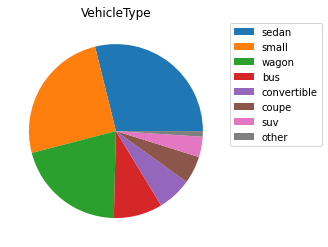

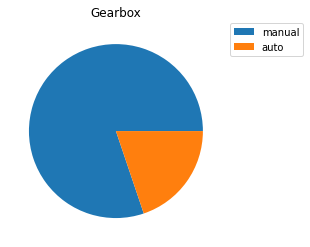

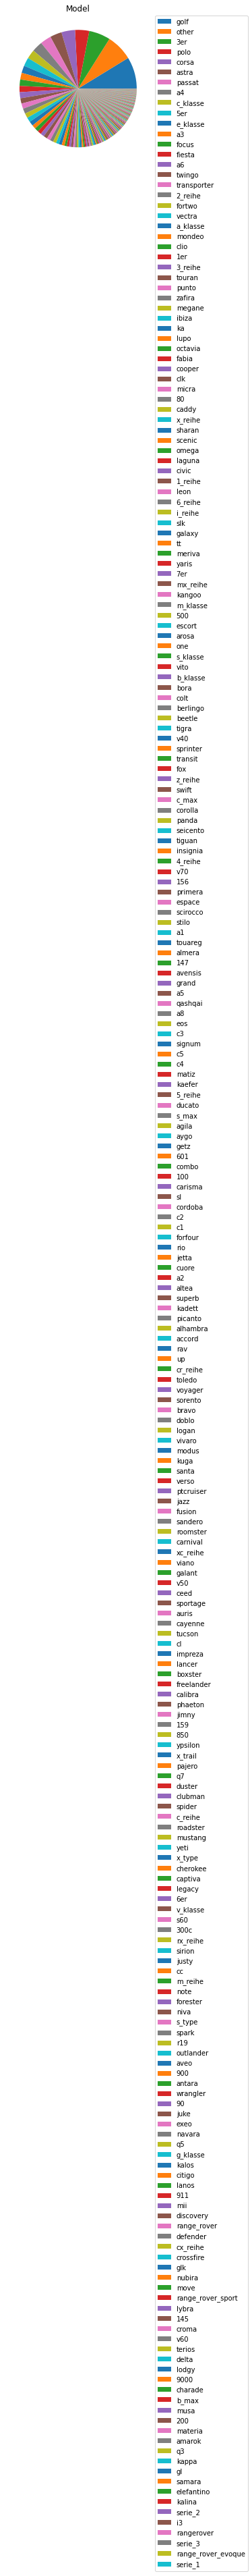

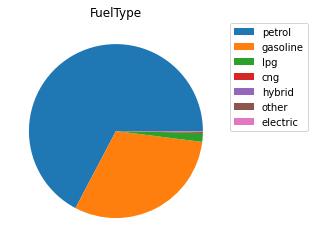

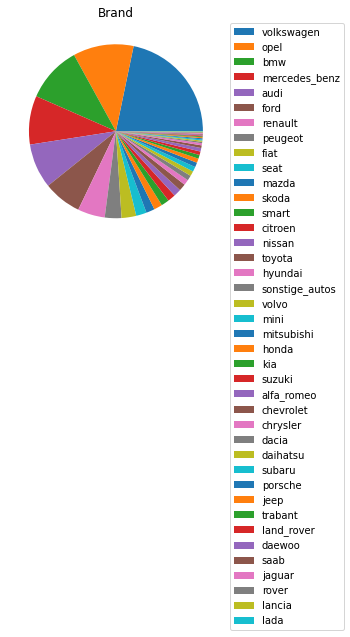

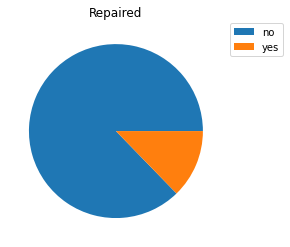

In [11]:
data_diagram(autos)

#### Изучение количественных признаков

In [12]:
def data_hist(data):
    for row in data.columns:
        if data[row].dtype == int:
            plt.hist(data[row], bins = 50)
            plt.xlabel(row)
            plt.ylabel('count')
            plt.title(f'Распределение {row}')
            plt.show()

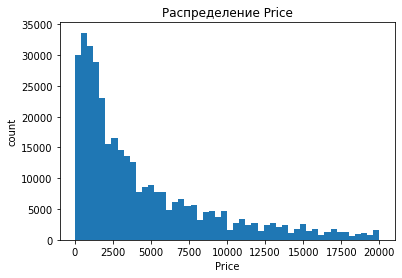

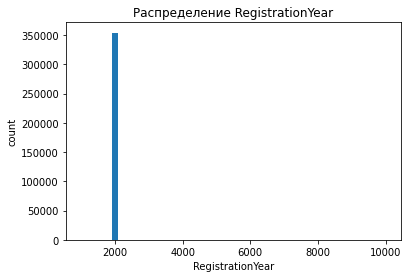

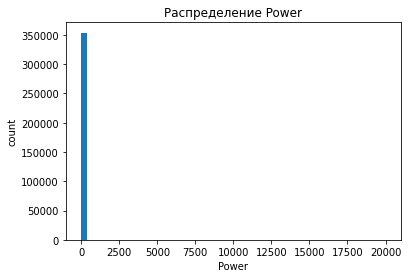

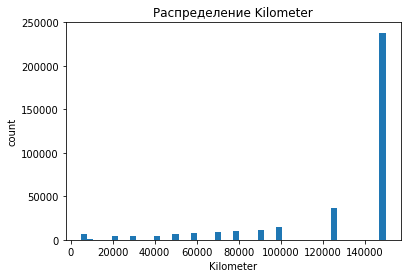

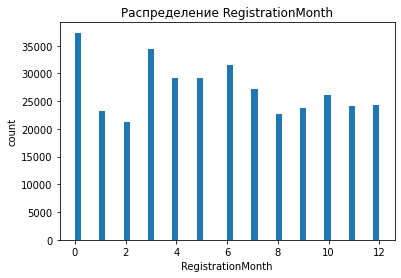

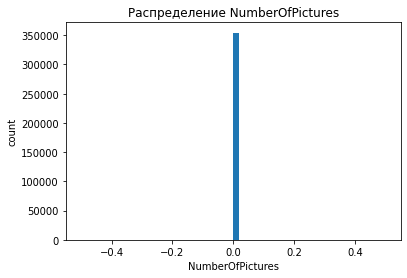

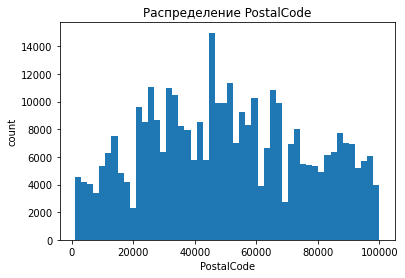

In [13]:
data_hist(autos)

Минимальная цена Price 0, что вероятно является выбросом. Также есть некорректные значения в столбцах RegistrationYear, Power.

### ОБработка пропущенных значений и дупликатов

In [14]:
# функция вывода пропусков и дупликатов
def data_dup_isna(data):
    print('Количество дупликатов')
    display(data.duplicated().sum())
    print('Количество пропусков')
    display(data.isna().sum())

In [15]:
data_dup_isna(autos)

Количество дупликатов


4

Количество пропусков


DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [16]:
autos[autos.duplicated()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 18:42:48,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:56:10,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 09:01:15,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 18:46:15,0,36391,2016-03-18 18:46:15


In [17]:
autos[autos.duplicated()].shape[0] / autos.shape[0]

1.1287669068118261e-05

Удалим дупликаты из датасета, поскольку их количество составляет меньше 1%

In [18]:
autos = autos.drop_duplicates()

Пропуски можно обработать следующим образом:
* VehicleType - установим значение 'unknown',
* Gearbox - самое популярное значение manual,
* Model установим значение 'unknown',
* FuelType установим значение 'unknown',
* Repaired - самое популярное значение no.

In [19]:
autos['Repaired'] = autos['Repaired'].fillna('no')
autos['Gearbox'] = autos['Gearbox'].fillna('manual')
autos['VehicleType'] = autos['FuelType'].fillna('unknown')
autos['Model'] = autos['Model'].fillna('unknown')
autos['FuelType'] = autos['FuelType'].fillna('unknown')

In [20]:
autos['FuelType'].unique()

array(['petrol', 'gasoline', 'unknown', 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

В ходе изучения вопроса было обнаружено, что 'petrol' и 'gasoline' - это одно и тоже. <br>
* gasoline - бензин в Америке, 
* petrol - бензин в Англии. <br>
Объединим в одно значение petrol:

In [21]:
autos['FuelType'] =autos['FuelType'].replace('gasoline', 'petrol')

In [22]:
autos['FuelType'].unique()

array(['petrol', 'unknown', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

### Обработка аномальных значений

Посмотрим какую долю занимают значения, где цена Price меньше 100:

In [23]:
autos[autos['Price']<100].shape[0]/ autos.shape[0]

0.03757143058710651

Менее 10%, можем удалить:

In [24]:
autos = autos.drop(autos[autos['Price']<100].index)

Удалим аномальные года регистрации(менее 1950 и более 2024):

In [25]:
autos[autos['RegistrationYear']<1950].shape[0]/ autos.shape[0]

0.00042515635491466086

In [26]:
autos = autos.drop(autos[autos['RegistrationYear']<1950].index)

In [27]:
autos[autos['RegistrationYear']>2024].shape[0]/ autos.shape[0]

0.00021120191489736173

In [28]:
autos = autos.drop(autos[autos['RegistrationYear']>2024].index)

<AxesSubplot:xlabel='DateCreated'>

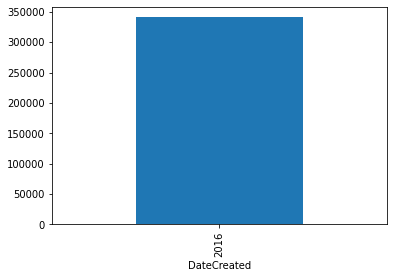

In [29]:
autos['DateCreated'].groupby(autos['DateCreated'].dt.year).count().plot(kind="bar")

Удалим аномальные значения Power(более 500). И с мощностью 0 тоже значения в выборку не берем:

In [30]:
autos[autos['Power']>500].shape[0]/ autos.shape[0]

0.001211733571181279

In [31]:
autos = autos.drop(autos[autos['Power']>500].index)

In [32]:
autos[autos['Power']<1].shape[0]/ autos.shape[0]

0.10258474065936003

In [33]:
autos = autos.drop(autos[autos['Power']<1].index)

### Подготовка выборок для обучения моделей

In [34]:
autos.corr()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.426843,0.509741,-0.386863,0.070640,NaN,0.064665
RegistrationYear,0.426843,1.000000,0.109373,-0.258656,0.025194,NaN,0.020596
Power,0.509741,0.109373,1.000000,0.105843,0.044257,NaN,0.055674
Kilometer,-0.386863,-0.258656,0.105843,1.000000,-0.015997,NaN,-0.010809
RegistrationMonth,0.070640,0.025194,0.044257,-0.015997,1.000000,NaN,0.002981
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.064665,0.020596,0.055674,-0.010809,0.002981,NaN,1.000000


Не включаем в выборку признаки DateCrawled, DateCreated,LastSeen, относящиеся скорее к объявлению, а не машине.<br>
Также исключаем признаки RegistrationMonth, NumberOfPictures, PostalCode, не влияющие на цену.:

In [35]:
autos_df = autos[['VehicleType','RegistrationYear','Gearbox', 'Power','Model', 'Kilometer','FuelType','Brand','Repaired','Price']]

In [36]:
data_info(autos_df)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired,Price
1,gasoline,2011,manual,190,unknown,125000,petrol,audi,yes,18300
2,gasoline,2004,auto,163,grand,125000,petrol,jeep,no,9800
3,petrol,2001,manual,75,golf,150000,petrol,volkswagen,no,1500
4,gasoline,2008,manual,69,fabia,90000,petrol,skoda,no,3600
5,petrol,1995,manual,102,3er,150000,petrol,bmw,yes,650
6,petrol,2004,manual,109,2_reihe,150000,petrol,peugeot,no,2200
8,petrol,2014,manual,125,c_max,30000,petrol,ford,no,14500
9,unknown,1998,manual,101,golf,150000,unknown,volkswagen,no,999
10,petrol,2004,manual,105,3_reihe,150000,petrol,mazda,no,2000
11,gasoline,2005,manual,140,passat,150000,petrol,volkswagen,yes,2799


<class 'pandas.core.frame.DataFrame'>
Int64Index: 305499 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       305499 non-null  object
 1   RegistrationYear  305499 non-null  int64 
 2   Gearbox           305499 non-null  object
 3   Power             305499 non-null  int64 
 4   Model             305499 non-null  object
 5   Kilometer         305499 non-null  int64 
 6   FuelType          305499 non-null  object
 7   Brand             305499 non-null  object
 8   Repaired          305499 non-null  object
 9   Price             305499 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 25.6+ MB


,RegistrationYear,Power,Kilometer,Price
count,305499.000000,305499.000000,305499.000000,305499.000000
mean,2003.324587,120.181709,128429.569328,4828.301513
std,6.888141,53.405193,36683.745011,4583.543025
min,1950.000000,1.000000,5000.000000,100.000000
25%,1999.000000,75.000000,125000.000000,1350.000000
50%,2003.000000,110.000000,150000.000000,3150.000000
75%,2008.000000,150.000000,150000.000000,6950.000000
max,2019.000000,500.000000,150000.000000,20000.000000


In [37]:
autos_df = autos_df.drop_duplicates()

In [38]:
X = autos_df.drop('Price', axis=1)
y = autos_df['Price']

In [39]:
num_col = X.select_dtypes(include='number').columns.tolist()
cat_col = X.select_dtypes(exclude='number').columns.tolist()

In [40]:
print(num_col)
print(cat_col)

['RegistrationYear', 'Power', 'Kilometer']
['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']


In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE
)
ohe_columns = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
num_columns = num_col

In [42]:
ohe_pipe = Pipeline(
    [(
        'simpleImputer_ohe',
        SimpleImputer(
            missing_values=np.nan,
            strategy='most_frequent'
        )
    ),
     (
         'ohe',
         OneHotEncoder(
             drop='first',
             handle_unknown='ignore',
             sparse=False
         )
     )
    ]
)

In [43]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [44]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression()
    )
])

## Обучение моделей

Для анализа важности признаков добавим функцию importances

In [45]:
def importances(model,features):
    features=features.columns
    importances = model.feature_importances_
    indexes = np.argsort(importances)
    
    plt.figure(figsize=(11, 5))
    plt.title('Важность признака')
    plt.barh(range(len(indexes)), importances[indexes])
    plt.yticks(range(len(indexes)), features[indexes])
    plt.xlabel('Относительная важность')
    plt.show()

### LinearRegression

In [46]:
param_grid = [
    
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],  
        
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [47]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv = 5,
    n_iter=5,
    scoring = 'neg_root_mean_squared_error',
    random_state = RANDOM_STATE,
    n_jobs = -1,
    error_score='raise'
)

In [48]:
start_time = timeit.default_timer()
pipe_final.fit(X_train, y_train)
linear_model_fit_time = timeit.default_timer() - start_time

In [49]:

start_time = timeit.default_timer()
RMSE_linear_time = mean_squared_error(y_train, pipe_final.predict(X_train))**(1/2)
predict_time_linear = timeit.default_timer() - start_time

In [50]:
randomized_search.fit(X_train, y_train)
RMSE_linear = -randomized_search.best_score_

### CatBoostRegressor

In [51]:
catboost_model = CatBoostRegressor(verbose=100,
                                   cat_features=cat_col,
                                   random_state=RANDOM_STATE)

In [52]:
param_grid = {
    'depth': [1, 5],
    'learning_rate': [0.1, 0.3]
}

randomized_search_catboost = RandomizedSearchCV(
    estimator=catboost_model, 
    param_distributions=param_grid, 
    scoring='neg_root_mean_squared_error', 
    cv=5,
    n_iter=3
)


In [53]:
start_time = timeit.default_timer()
catboost_model.fit(X_train, y_train)
catboost_model_fit_time = timeit.default_timer() - start_time

Learning rate set to 0.093621
0:	learn: 4397.5151513	total: 282ms	remaining: 4m 41s
100:	learn: 1885.9672504	total: 15.4s	remaining: 2m 16s
200:	learn: 1808.7902017	total: 30s	remaining: 1m 59s
300:	learn: 1769.6574346	total: 44.5s	remaining: 1m 43s
400:	learn: 1747.4424792	total: 59.5s	remaining: 1m 28s
500:	learn: 1730.7173563	total: 1m 14s	remaining: 1m 14s
600:	learn: 1716.9407465	total: 1m 30s	remaining: 59.9s
700:	learn: 1704.7856707	total: 1m 45s	remaining: 45.1s
800:	learn: 1694.5212320	total: 2m	remaining: 29.9s
900:	learn: 1684.7345059	total: 2m 15s	remaining: 14.9s
999:	learn: 1676.4534097	total: 2m 30s	remaining: 0us


In [54]:
start_time = timeit.default_timer()
RMSE_catboost_time = mean_squared_error(y_train, catboost_model.predict(X_train))**(1/2)
predict_time_catboost = timeit.default_timer() - start_time

In [55]:
randomized_search_catboost.fit(X_train, y_train)
RMSE_catboost = -randomized_search_catboost.best_score_

0:	learn: 4395.4045723	total: 151ms	remaining: 2m 30s
100:	learn: 1918.2871520	total: 10.3s	remaining: 1m 31s
200:	learn: 1841.8983301	total: 20.2s	remaining: 1m 20s
300:	learn: 1804.5390686	total: 29.6s	remaining: 1m 8s
400:	learn: 1782.5146300	total: 39.5s	remaining: 58.9s
500:	learn: 1763.4739225	total: 49.3s	remaining: 49.1s
600:	learn: 1748.2277142	total: 59.3s	remaining: 39.3s
700:	learn: 1735.7114632	total: 1m 9s	remaining: 29.6s
800:	learn: 1724.9197035	total: 1m 19s	remaining: 19.8s
900:	learn: 1714.1818085	total: 1m 29s	remaining: 9.88s
999:	learn: 1705.7122885	total: 1m 40s	remaining: 0us
0:	learn: 4397.3658284	total: 154ms	remaining: 2m 33s
100:	learn: 1922.8432343	total: 9.78s	remaining: 1m 27s
200:	learn: 1839.7555365	total: 19.6s	remaining: 1m 18s
300:	learn: 1803.5656069	total: 29s	remaining: 1m 7s
400:	learn: 1779.0112855	total: 38.9s	remaining: 58s
500:	learn: 1760.4010008	total: 48.4s	remaining: 48.2s
600:	learn: 1747.1573984	total: 58s	remaining: 38.5s
700:	learn: 1

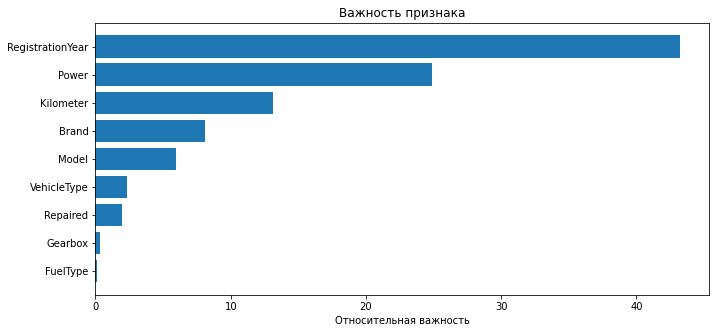

In [56]:
importances(catboost_model,X_train)

### LightGBM 

In [57]:
X_train[cat_col] = X_train[cat_col].astype('category')
X_test[cat_col] = X_test[cat_col].astype('category')

In [58]:
lgbm_model = LGBMRegressor(objective='root_mean_squared_error',
                           random_state=RANDOM_STATE,
                           verbose=-1)

In [59]:
param_grid = {
    'learning_rate': [0.1, 0.3, 0.5, 1],  
    'max_depth': [1, 2, 6]
}

randomized_search_lgbm = RandomizedSearchCV(
    estimator=lgbm_model, 
    param_distributions=param_grid, 
    scoring='neg_root_mean_squared_error', 
    cv=5,
    n_iter=5
)

In [60]:
start_time = timeit.default_timer()
lgbm_model.fit(X_train, y_train)
lgbm_model_fit_time = timeit.default_timer() - start_time

In [61]:
start_time = timeit.default_timer()
RMSE_lgbm_time = mean_squared_error(y_train, lgbm_model.predict(X_train))**(1/2)
predict_time_lgbm = timeit.default_timer() - start_time

In [62]:
randomized_search_lgbm.fit(X_train, y_train)
RMSE_lgbm = -randomized_search_lgbm.best_score_

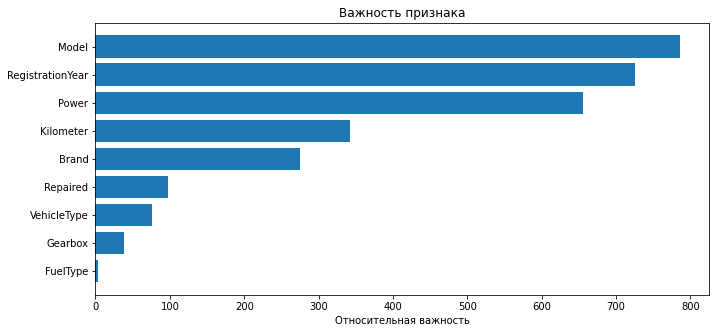

In [63]:
importances(lgbm_model,X_train)

## Анализ моделей

In [64]:
print('Linear-время', linear_model_fit_time)
print('Catboost-время', catboost_model_fit_time)
print('LGBM-время', lgbm_model_fit_time)

Linear-время 24.89746373699745
Catboost-время 152.9914419350098
LGBM-время 4.1957601009635255


In [65]:
print('Linear-время предсказания', predict_time_linear)
print('Catboost-время предсказания', predict_time_catboost)
print('LGBM-время предсказания', predict_time_lgbm)

Linear-время предсказания 1.2745475529809482
Catboost-время предсказания 1.1416971490252763
LGBM-время предсказания 1.9020184259861708


In [66]:
print('Linear-RMSE', RMSE_linear)
print('Catboost-RMSE', RMSE_catboost)
print('LGBM-RMSE', RMSE_lgbm)

Linear-RMSE 2781.5264069161403
Catboost-RMSE 1761.4605632555067
LGBM-RMSE 1746.0210546812548


Вывод:
<br> Лучше всего показала себя модель  LightGBM - с самой высокой скоростью обучения и с лучшим результатом RMSE.

In [67]:
start_time = timeit.default_timer()
RMSE_lgbm_test = mean_squared_error(y_test, lgbm_model.predict(X_test))**(1/2)
predict_time_lgbm_test = timeit.default_timer() - start_time

In [68]:
print('LGBM-RMSE и время предсказания на тестовой выборке', RMSE_lgbm_test, predict_time_lgbm_test)

LGBM-RMSE и время предсказания на тестовой выборке 1732.475421929691 0.5552372239762917


Таким образом модель LGBM хорошо себя показала и на тестовой выборке, учтены важные для критерии:
* качество предсказания;
* время обучения модели;
* время предсказания модели.